# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pip install folium
import folium

# **Load data**

In [2]:
test = pd.read_csv('./data/test.csv')
sales = pd.read_csv('./data/sales_train.csv')
shops = pd.read_csv('./data/shops.csv')
items = pd.read_csv('./data/items.csv')
item_cats = pd.read_csv('./data/item_categories.csv')

# **Create dataset**

결측치 제거

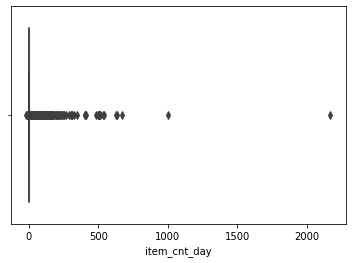

In [3]:
sns.boxplot(x=sales.item_cnt_day)

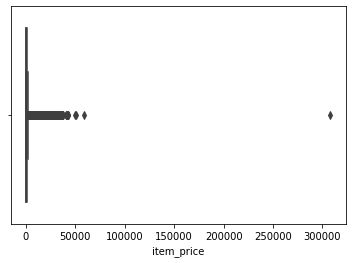

In [4]:
sns.boxplot(x=sales.item_price)

In [5]:
train = sales[(sales.item_price < 100000) & (sales.item_price > 0)]
train = train[sales.item_cnt_day < 1001]

/home/ssac12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Detect same shops

In [6]:
# shops.shop_id에서 중복값을 찾아 shop_name을 출력
print(shops[shops.shop_id.isin([0, 57])]['shop_name'])
print(shops[shops.shop_id.isin([1, 58])]['shop_name'])
print(shops[shops.shop_id.isin([40, 39])]['shop_name'])

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


In [7]:
# train.shop_id가 x인 행에서, shop_id 값을 y로 바꾼다
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

In [8]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


Simple train dataset

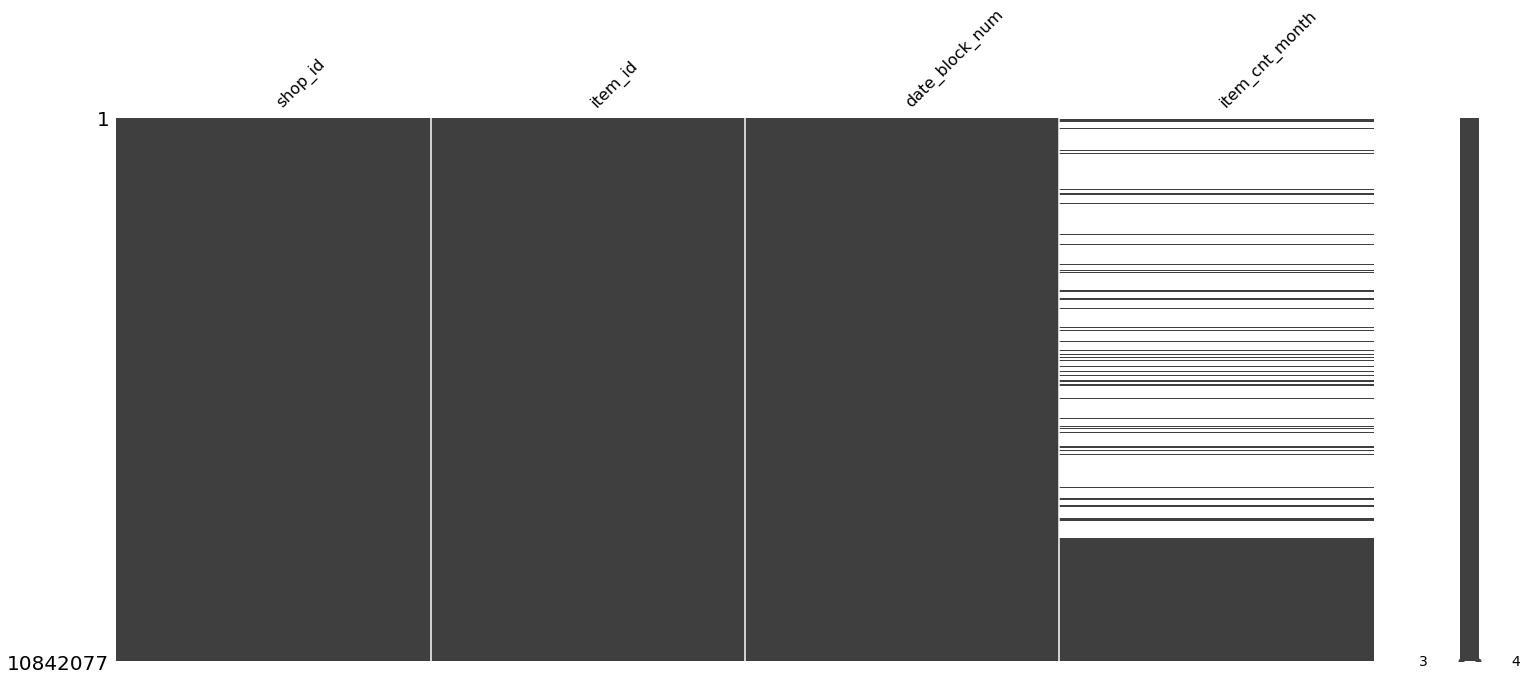

In [9]:
import missingno as msno
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 

# shop_id, item_id, date_block_num을 중복없이 합치기
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

#월별 count를 합산
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

# df랑 group이랑 merge 연산을 통해 합침
df = pd.merge(df, group, on=index_cols, how='left')


msno.matrix(df)

In [10]:
# 위 시각화를 통해 결측치값이 있다는 것을 확인하고 후처리 작업을 함. 
# 결과적으로 특정 상점에서 제품이 월별 얼만큼 팔렸는지를 표현함 
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


Add test

In [11]:
# test 데이터에 대해서도 똑같이 수행함. (date_block_num을 34로 통일)
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)

In [12]:
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID
0,59,22154,0,1.0,0.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


# Feature engineering

**Shop features**

* City of a shop
* City coords
* Country part (0-4) based on the map 

In [13]:
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [14]:
# shop_name을 통해 shop['city']를 추가.
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

# 지역별 위도, 경도를 저장, 지역을 5등분함.
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]

In [15]:
# 위경도 시각화
from folium.plugins import MarkerCluster
# for row in shops:
#     print(row)
center= [55.75649975403093, 37.61385742301314]
map_osm = folium.Map(location=[center[0], center[1]], zoom_start=8)
marker_cluster = MarkerCluster().add_to(map_osm)
# try:
#     for x in shops.loc:
#         if x.city_coord_1 and x.city_coord_2:
#             folium.Marker([x.city_coord_1, x.city_coord_2]).add_to(map_osm)
# except:
#     pass
try:
    for x in shops.loc:
        if x.city_coord_1 and x.city_coord_2:
            folium.Marker(
                location=[x.city_coord_1, x.city_coord_2],
                icon=folium.Icon(color='red',icon='ok'),
            ).add_to(marker_cluster)
except:
    pass
map_osm

In [16]:
shops.head(5)

,shop_id,city_code,city_coord_1,city_coord_2,country_part
0,0,29,62.028098,129.732555,4
1,1,29,62.028098,129.732555,4
2,2,0,44.609764,40.100516,3
3,3,1,55.809450,37.958060,1
4,4,2,53.430580,50.119000,3


In [17]:
# shop_id기준으로 위도, 경도 등을 추가함
df = pd.merge(df, shops, on=['shop_id'], how='left')

In [18]:
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2


**Item features**

* Item category
* More common item category

In [19]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [20]:
# item의 카테고리 대분류, 소분류 만듬.
map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }

items = pd.merge(items, item_cats, on='item_category_id')

items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]

In [21]:
df = pd.merge(df, items, on=['item_id'], how='left')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,37
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,58
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,58
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,56
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,59


**Date features**

* Weekends count (4 or 5)
* Number of days in a month

In [22]:
# 년, 월, 일을 뽑아내서, 해당 월에 주수, 일수를 저장.
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])
df.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,37,4,31
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,58,4,31
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,58,4,31
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,56,4,31
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,59,4,31
5,59,2565,0,0.0,0.0,30,57.62987,39.87368,2,13,56,4,31
6,59,2572,0,0.0,0.0,30,57.62987,39.87368,2,13,55,4,31
7,59,2573,0,0.0,0.0,30,57.62987,39.87368,2,13,55,4,31
8,59,2574,0,2.0,0.0,30,57.62987,39.87368,2,13,55,4,31
9,59,2593,0,0.0,0.0,30,57.62987,39.87368,2,13,55,4,31


**Interaction features**

* Item is new
* Item was bought in this shop before

In [23]:
# item_id별로 가장 처음에 팔린 date_block_num을 구함
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_item_block.head(5)

,item_id,date_block_num,item_first_interaction
0,0,20,1
1,1,15,1
2,2,19,1
3,3,18,1
4,4,20,1


In [24]:
# shop_id별, item_id별 가장 처음에 팔린 일자인 first_date_block_num을 저장
first_shop_item_buy_block = df[df['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']
first_shop_item_buy_block.head(5)

,shop_id,item_id,date_block_num,first_date_block_num
0,2,0,20,20
1,2,1,15,15
2,2,2,19,19
3,2,3,18,18
4,2,4,20,20


In [25]:
# 빈 값 채움.
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)
 
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 
df.tail(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before
11056272,45,18454,34,0.0,214195.0,19,53.20007,50.15,4,13,55,5,30,0,1
11056273,45,16188,34,0.0,214196.0,19,53.20007,50.15,4,14,64,5,30,0,1
11056274,45,15757,34,0.0,214197.0,19,53.20007,50.15,4,13,55,5,30,0,1
11056275,45,19648,34,0.0,214198.0,19,53.20007,50.15,4,11,40,5,30,0,1
11056276,45,969,34,0.0,214199.0,19,53.20007,50.15,4,11,37,5,30,0,1


**Basic lag features**

In [26]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

In [27]:
# 1,2,3달전에 팔린양을 저장
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')
df.tail(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
11056272,45,18454,34,0.0,214195.0,19,53.20007,50.15,4,13,55,5,30,0,1,1.0,0.0,0.0
11056273,45,16188,34,0.0,214196.0,19,53.20007,50.15,4,14,64,5,30,0,1,0.0,0.0,NaN
11056274,45,15757,34,0.0,214197.0,19,53.20007,50.15,4,13,55,5,30,0,1,0.0,0.0,0.0
11056275,45,19648,34,0.0,214198.0,19,53.20007,50.15,4,11,40,5,30,0,1,0.0,0.0,0.0
11056276,45,969,34,0.0,214199.0,19,53.20007,50.15,4,11,37,5,30,0,1,0.0,0.0,0.0


In [28]:
#shop_price와 item_price의 평균을 구해, lag_feature에 넣어 item_shop_price_avg 열을 형성(시계열 데이터)

index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)

In [29]:
df

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,...,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,214195.0,19,53.20007,50.15000,4,13,...,5,30,0,1,1.0,0.0,0.0,0.0,-1.0,-1.0
11056273,45,16188,34,0.0,214196.0,19,53.20007,50.15000,4,14,...,5,30,0,1,0.0,0.0,NaN,-1.0,-1.0,NaN
11056274,45,15757,34,0.0,214197.0,19,53.20007,50.15000,4,13,...,5,30,0,1,0.0,0.0,0.0,-1.0,-1.0,-1.0
11056275,45,19648,34,0.0,214198.0,19,53.20007,50.15000,4,11,...,5,30,0,1,0.0,0.0,0.0,-1.0,-1.0,-1.0


**Target encoding**

In [30]:
#Add target encoding for items for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_target_enc')
df.drop(['item_target_enc'], axis=1, inplace=True)

In [31]:
#Add target encoding for item/city for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.drop(['item_loc_target_enc'], axis=1, inplace=True)

In [32]:
#Add target encoding for item/shop for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

df['item_shop_target_enc'] = (df['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_shop_target_enc')
df.drop(['item_shop_target_enc'], axis=1, inplace=True)

Extra interaction features

In [33]:
#For new items add avg category sales for last 3 months
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_cat_avg')
df.drop(['new_item_cat_avg'], axis=1, inplace=True)

In [34]:
#For new items add avg category sales in a separate store for last 3 months
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code', 'shop_id'], how='left')

df['new_item_shop_cat_avg'] = (df['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_shop_cat_avg')
df.drop(['new_item_shop_cat_avg'], axis=1, inplace=True)

Add sales for the last three months for similar item (item with id = item_id - 1;
kinda tricky feature, but increased the metric significantly)

In [35]:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')

Remove data for the first three months

In [36]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,...,item_shop_target_enc_lag_3,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv
1122795,25,8092,3,3.0,0.0,13,55.75222,37.61556,1,11,...,4.0,0.643066,0.517578,0.293945,1.996094,1.446289,0.891113,7.0,5.0,13.0
1122796,25,7850,3,3.0,0.0,13,55.75222,37.61556,1,8,...,6.0,3.351562,0.745605,1.126953,4.867188,0.898438,1.947266,0.0,0.0,0.0
1122797,25,8051,3,3.0,0.0,13,55.75222,37.61556,1,14,...,0.0,0.027664,0.036224,0.160645,0.000000,0.416748,1.019531,0.0,0.0,0.0
1122798,25,8088,3,1.0,0.0,13,55.75222,37.61556,1,13,...,0.0,0.333252,0.108521,0.208130,1.000000,0.303955,0.534668,0.0,1.0,0.0
1122799,25,8089,3,1.0,0.0,13,55.75222,37.61556,1,13,...,0.0,0.333252,0.108521,0.208130,1.000000,0.303955,0.534668,2.0,0.0,3.0


In [37]:
#Save dataset
df.drop(['ID'], axis=1, inplace=True, errors='ignore')
df.to_pickle('df.pkl')

# Train model

In [38]:
df = pd.read_pickle('df.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9933482 entries, 1122795 to 11056276
Data columns (total 38 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   shop_id                      int32  
 1   item_id                      int32  
 2   date_block_num               int32  
 3   item_cnt_month               float16
 4   city_code                    int64  
 5   city_coord_1                 float64
 6   city_coord_2                 float64
 7   country_part                 int64  
 8   item_category_common         int64  
 9   item_category_code           int64  
 10  weeknd_count                 int64  
 11  days_in_month                int64  
 12  item_first_interaction       int8   
 13  shop_item_sold_before        int8   
 14  item_cnt_month_lag_1         float16
 15  item_cnt_month_lag_2         float16
 16  item_cnt_month_lag_3         float16
 17  item_shop_price_avg_lag_1    float16
 18  item_shop_price_avg_lag_2    float1

In [39]:
# 시계열 데이터
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del df

In [40]:
'''
모델로는 LightGBM의 성능이 가장 좋은것 같아 사용함.
모델의 rmse 값이 낮을 수록 케글 점수 또한 잘 나온다는 것을 알아챔. 
파라미터들을 여러가지 방향으로 조절해보면서 기준을 rmse값을 가장 최소화 하는 파라미터를 찾고자 하였음.
1. objective의 mse와 rmse는 큰 차이가 나지 않았다.
2. learning rate는 올리지 말자
3. 파라미터 수를 줄이고자 bagging fraction, bagging freq을 제거했더니 효과가 좋았다. -> 적당히 파라미터 쓰는게 좋다.
4. num_leaves는 적당히
5. learning rate도 무작정 내리는 건 no, 적당히

'''


feature_name = X_train.columns.tolist()

#score : 0.86755
#start : 1.16752 / 1.1006
#end : 0.744978 / 0.892711
#best : 0.755667 / 0.892105
'''
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 300,
    'learning_rate': 0.02,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}
'''

#score : 0.87415
#strart : 1.18751 / 1.11665
#end : 0.778642 / 0.902807
#best : 0.778642 / 0.902807 
'''
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}
'''
# gbm_submission3.csv
#score : 0.85885
#strart : 1.18857 / 1.11746
#end : 0.745828 / 0.902225
#best : 0.754902 / 0.901273
'''
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1
}
'''
# gbm_submission4.csv
#score : 0.86755
#strart : 1.16572 / 1.1006
#end : 0.744978 / 0.892711
#best : 0.755667 / 0.892105

'''
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 300,
    'learning_rate': 0.02,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}
'''
# gbm_submission5.csv
#score : 
#strart : 1.18834 / 1.11763
#end : 0.732529 / 0.899406
#best : 0.758514 / 0.896786

'''
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'learning_rate': 0.01,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}
'''

# gbm_submission6.csv
#score : 0.85211
#strart : 1.18834 / 1.11763
#end : 0.715483 / 0.903551
#best : 0.737616 / 0.901977
# 최소의 파라미터만 사용하고자 해서 bagging 파라미터를 지웠더니 좋았다.

params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'learning_rate': 0.01,
    'min_data_in_leaf':10,
    'feature_fraction': 0.75,
    'seed': 1,
    'verbose': 1
}

# gbm_submission7.csv
#score : 
#strart : 1.1867 / 1.09813
#end : 0.699899 / 0.906848
#best : 0.739136 / 0.904722
# num_laeves를 너무 늘리는 것도 안좋다.
'''
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 2055,
    'learning_rate': 0.01,
    'min_data_in_leaf':10,
    'feature_fraction': 0.75,
    'seed': 1,
    'verbose': 1
}
'''
# gbm_submission8.csv
#score : 
#strart : 1.20198 / 1.12723
#end : 0.740116 / 0.90107
#best : 0.755785 / 0.900642
# learning rate를 너무 낮추어도 안좋다.
'''
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'learning_rate': 0.005,
    'min_data_in_leaf':10,
    'feature_fraction': 0.75,
    'seed': 1,
    'verbose': 1
}
'''

"\nparams = {\n    'objective': 'rmse',\n    'metric': 'rmse',\n    'num_leaves': 1023,\n    'learning_rate': 0.005,\n    'min_data_in_leaf':10,\n    'feature_fraction': 0.75,\n    'seed': 1,\n    'verbose': 1\n}\n"

In [41]:
feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]



lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)


/home/ssac12/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.357141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4397
[LightGBM] [Info] Number of data points in the train set: 9481110, number of used features: 37


/home/ssac12/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/ssac12/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.296231
Training until validation scores don't improve for 100 rounds
[5]	training's rmse: 1.18808	valid_1's rmse: 1.11801
[10]	training's rmse: 1.1606	valid_1's rmse: 1.09877
[15]	training's rmse: 1.13526	valid_1's rmse: 1.0811
[20]	training's rmse: 1.11113	valid_1's rmse: 1.06458
[25]	training's rmse: 1.08889	valid_1's rmse: 1.04967
[30]	training's rmse: 1.06898	valid_1's rmse: 1.03626
[35]	training's rmse: 1.04973	valid_1's rmse: 1.02399
[40]	training's rmse: 1.03132	valid_1's rmse: 1.01203
[45]	training's rmse: 1.01411	valid_1's rmse: 1.00237
[50]	training's rmse: 0.999523	valid_1's rmse: 0.993544
[55]	training's rmse: 0.984793	valid_1's rmse: 0.98489
[60]	training's rmse: 0.971122	valid_1's rmse: 0.977155
[65]	training's rmse: 0.958651	valid_1's rmse: 0.971091
[70]	training's rmse: 0.947071	valid_1's rmse: 0.964736
[75]	training's rmse: 0.936465	valid_1's rmse: 0.958448
[80]	training's rmse: 0.926266	valid_1's rmse: 0.953062
[85]	traini

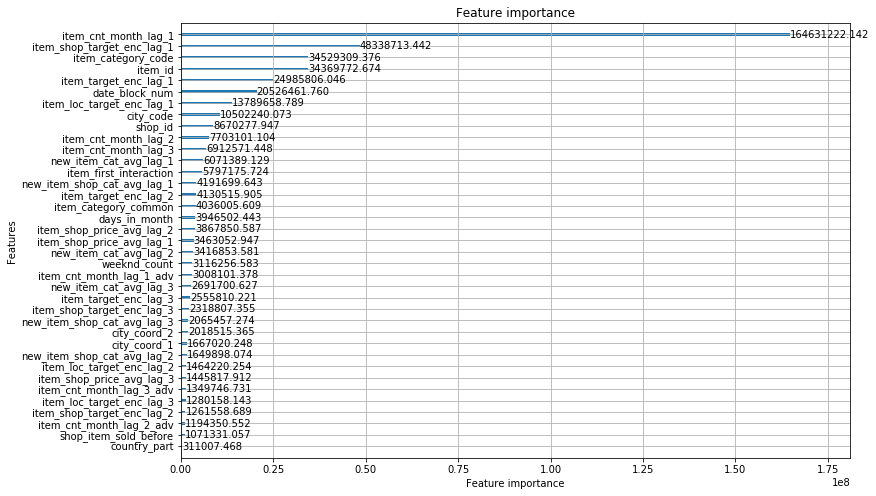

In [42]:
# 데이터들의 영향도를 그래프로 표현해보니, 전처리한 데이터가 영향을 가장 많이 준 것으로 보임 
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

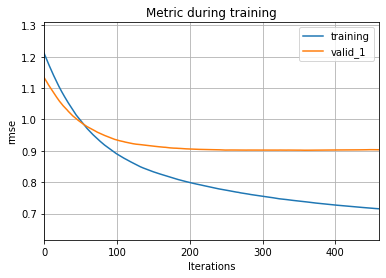

In [43]:
# train 과 validation의 차이가 0.2정도 차이가 난다. 
lgb.plot_metric(evals_result, metric='rmse')
plt.show()

In [46]:
ZZ = X_train[['date_block_num',
       'country_part', 'weeknd_count', 'days_in_month',
       'item_first_interaction', 'shop_item_sold_before',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'item_target_enc_lag_1',
       'item_target_enc_lag_2', 'item_target_enc_lag_3',
       'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2',
       'item_loc_target_enc_lag_3', 'item_shop_target_enc_lag_1',
       'item_shop_target_enc_lag_2', 'item_shop_target_enc_lag_3',
       'new_item_cat_avg_lag_1', 'new_item_cat_avg_lag_2',
       'new_item_cat_avg_lag_3', 'new_item_shop_cat_avg_lag_1',
       'new_item_shop_cat_avg_lag_2', 'new_item_shop_cat_avg_lag_3',
       'item_cnt_month_lag_1_adv', 'item_cnt_month_lag_2_adv',
       'item_cnt_month_lag_3_adv']]

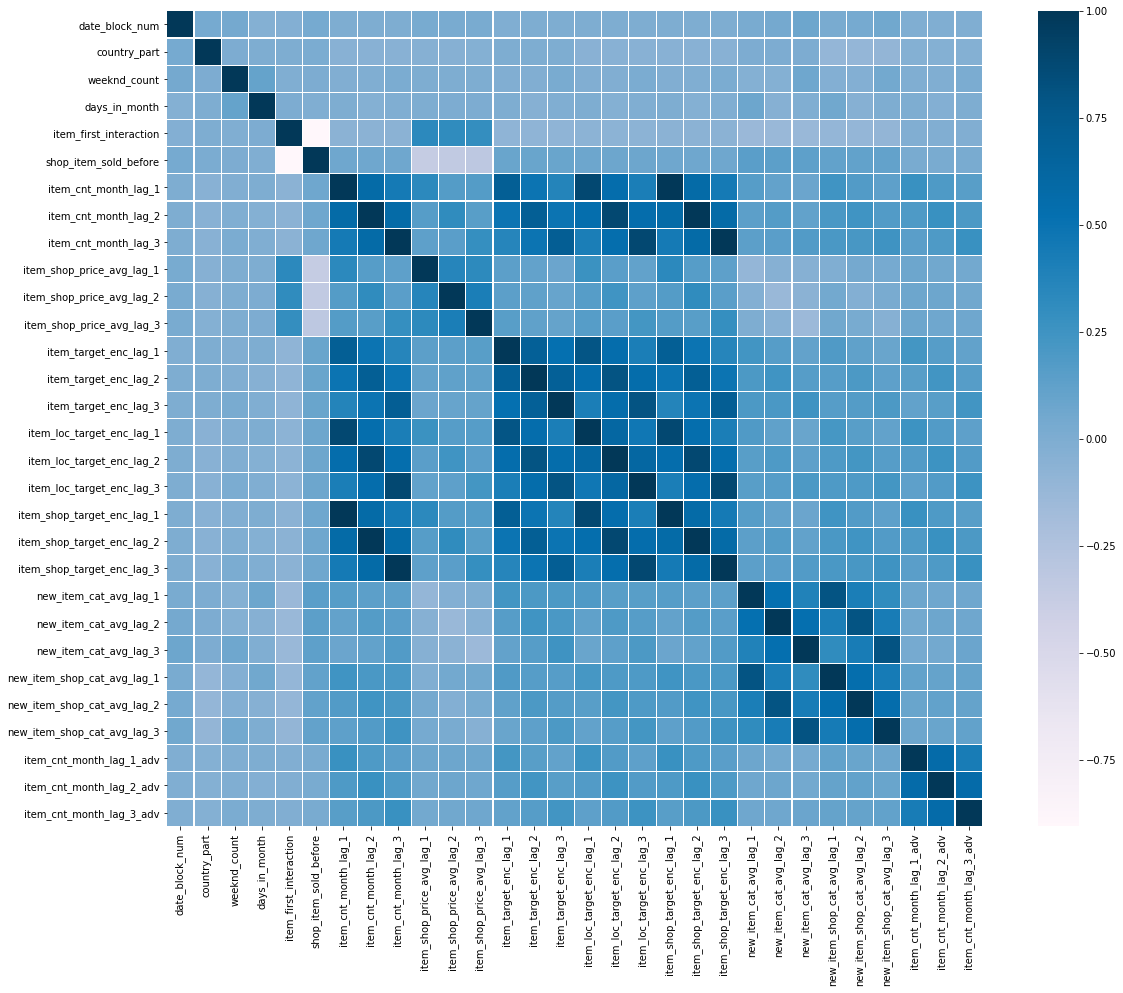

In [47]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20,15))
sns.heatmap(ZZ.corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = "white"
            )

# 전처리 하기 전의 데이터간의 상관관계는 적은 것으로 보이나, 전처리 후의 데이터들은 상대적으로 높은 상관관계를 보임. 

In [44]:
test = pd.read_csv('./data/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('gbm_submission8.csv', index=False)